# _Robust Out-of-Distribution Detection in Neural Networks Using Variance Control Charts on Layer Activations_

## 0. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Changing visual style for plots
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Times New Roman'

# Set seed for reproducibility
seed = 666
np.random.seed(seed)
tf.random.set_seed(seed)

# Ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

## 1. Generating Toy Data

$$ x_{ij} \sim Uniform(0,1) \text{  for  j = 1,2   and   } i=1,..,2^9$$
$$ f(x) = sin(2\pi x_1)sin(2\pi x_2) $$
$$ \epsilon \sim N(0,0.1^2) $$
$$ y = f(x) + \epsilon $$
$$ \text{OOD inputs} \sim N([1.5,1.5], 0.1 \cdot I) $$

In [2]:
# Function to generate synthetic training data
def generate_training_data(n_samples, n_features):
    X = np.random.uniform(0, 1, n_features * n_samples).reshape(n_samples, n_features)
    epsilon = np.random.normal(0, 0.1, n_samples).reshape(-1, 1)
    f_x = np.sin(2 * np.pi * X[:, 0]) * np.sin(2 * np.pi * X[:, 1])
    y = f_x.reshape(-1, 1) + epsilon
    return X, y

# Generate OOD and additional in-distribution data for validation
def generate_validation_data(n_samples_in, n_samples_out, n_features):
    # OOD samples
    X_out = np.random.multivariate_normal([1.5, 1.5], 0.1 * np.eye(n_features), n_samples_out)
    # In-distribution samples
    X_in = np.random.uniform(0, 1, n_features * n_samples_in).reshape(n_samples_in, n_features)
    # Concatenate to form validation dataset
    X_test = np.concatenate([X_out, X_in])
    return X_test

# Generate training data (512 samples, 2 features)
n_samples = np.power(2, 9)
n_features = 2
X_train, y_train = generate_training_data(n_samples, n_features)

# Generate validation data (200 OOD and 200 in-distribution samples)
X_test = generate_validation_data(200, 200, n_features)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'validation data shape: {X_test.shape} - 200 OOD + 200 In-distribution')

X_train shape: (512, 2)
y_train shape: (512, 1)
validation data shape: (400, 2) - 200 OOD + 200 In-distribution


## 2. Defining and Training the Neural Network

$$ MLP(2, 20, 32, 20, 2, 1) $$

In [3]:
# Define the MLP model with Batch Normalization layers
model = tf.keras.Sequential([
        tf.keras.Input(shape=(2,)),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, activation='linear')
    ])

# Compile the model (Adam optimizer with learning rate decay)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-4), 
              loss=tf.keras.losses.MeanSquaredError())

# Train the model for 400 epochs
model.fit(X_train, y_train, epochs=400, batch_size=32, verbose=0)

## 3. Extracting Activations

In [4]:
# Create a model to extract activations from Dense layers (ignoring BatchNorm layers)
h_model = tf.keras.Model(inputs=model.layers[0].input,
                         outputs=[layer.output for layer in model.layers[:-1:2]])

# Extract activations for training and test data
h_train = h_model(X_train)  # Activations from Dense layers (training)
h_test = h_model(X_test)    # Activations from Dense layers (test)

## 4. Calculating Range and Mean of Variance Across Activations

$$  \bar R = \frac{\sum_{i=1}^{512}R_i}{512} $$
$$ \bar{\bar x} = \frac{\sum_{i=1}^{512}\bar x_i}{512} $$

In [5]:
# Calculate variance of activations across neurons for each training example
variance_train = pd.DataFrame([np.var(layer_activations, axis=1) for layer_activations in h_train]).T
variance_train['x_i'] = np.mean(variance_train, axis=1)   # Mean variance
variance_train['R_i'] = np.max(variance_train, axis=1) - np.min(variance_train, axis=1) # Range (R_i)

# Similarly, for test data
variance_test = pd.DataFrame([np.var(layer_activations, axis=1) for layer_activations in h_test]).T
variance_test['x_i'] = np.mean(variance_test, axis=1)
variance_test['R_i'] = np.max(variance_test, axis=1) - np.min(variance_test, axis=1)

In [6]:
variance_train

,0,1,2,3,x_i,R_i
0,0.043199,0.152277,0.242756,0.117982,0.139053,0.199557
1,0.035850,0.094652,0.156280,0.165029,0.112953,0.129179
2,0.023885,0.337341,1.197891,0.000000,0.389779,1.197891
3,0.005215,0.068638,0.386862,0.000000,0.115179,0.386862
4,0.008465,0.105744,0.249228,0.000670,0.091027,0.248559
...,...,...,...,...,...,...
507,0.044753,0.181368,0.236640,0.000000,0.115690,0.236640
508,0.008031,0.044017,0.327344,0.256806,0.159049,0.319313
509,0.028083,0.060316,0.237400,0.008183,0.083495,0.229217
510,0.020167,0.265656,0.523171,0.106365,0.228840,0.503003


## 5. Control Limits Calculations

$$ \text{Control Limits for the R Chart:}$$
$$  UCL = D_4 \bar R $$
$$  \text{Center line} = \bar R $$
$$  LCL = D_3 \bar R $$

In [7]:
# Control chart constants for R-chart
R_bar = np.mean(variance_train['R_i'])    # Average range
D_3, D_4 = 0, 2.114      # Constants for R-chart
range_lower_limit = R_bar * D_3    # Lower control limit (LCL) for R
range_upper_limit = R_bar * D_4    # Upper control limit (UCL) for R
print(f'R_bar: {R_bar}')
print(f'UCL: {range_upper_limit}')
print(f'LCL: {range_lower_limit}')

R_bar: 0.4064289331436157
UCL: 0.8591907646656036
LCL: 0.0


$$ \text{Control Limits for the } \bar x \text{ Chart:}$$
$$  UCL = \bar{\bar x} + A_2 \bar R $$
$$  \text{Center line} = \bar{\bar x} $$
$$  LCL = \bar{\bar x} - A_2 \bar R $$

In [8]:
# X-bar control chart constants for variance (x-chart)
X_bar = np.mean(variance_train['x_i']) # Mean of x
A_2 = 0.729    # Constant for x-chart
mean_upper_limit = X_bar + (A_2 * R_bar)  # UCL for x-chart
mean_lower_limit = X_bar - (A_2 * R_bar)  # LCL for x-chart
print(f'X_bar: {X_bar}')
print(f'UCL: {mean_upper_limit}')
print(f'LCL: {mean_lower_limit}')

X_bar: 0.17177113890647888
UCL: 0.46805783116817473
LCL: -0.12451555335521697


## 6. Estimating The Parameters: μ and σ

In [9]:
out_of_control = np.where(variance_train['R_i'] >= range_upper_limit)[0]

while len(out_of_control) > 0:
    variance_train = variance_train.loc[~variance_train.index.isin(out_of_control)].reset_index(drop=True)
    R_bar = np.mean(variance_train['R_i'])
    range_upper_limit = R_bar * D_4
    X_bar = np.mean(variance_train['x_i'])
    mean_upper_limit = X_bar + (A_2 * R_bar)
    mean_lower_limit = X_bar - (A_2 * R_bar)
    out_of_control = np.where(variance_train['R_i'] >= range_upper_limit)[0]

In [10]:
d_2 = 2.059
A = 1.5
D_2, D_1 = 4.698, 0
sigma = R_bar / d_2
mu = X_bar
print(f'Estimated parameters: Mu={mu}, Sigma={sigma}')

# In-Control limits calculation for x-chart
mean_upper_limit = mu + (A * sigma)
mean_lower_limit = mu - (A * sigma)
print(f'X-Chart Control Limits: UCL={mean_upper_limit}, LCL={mean_lower_limit} ')

# Same but for R-chart
range_upper_limit = D_2 * sigma
range_lower_limit = D_1 * sigma
print(f'R-Chart Control Limits: UCL={range_upper_limit}, LCL={range_lower_limit} ')

Estimated parameters: Mu=0.15392841398715973, Sigma=0.16895159463850024
X-Chart Control Limits: UCL=0.40735580594491005, LCL=-0.0994989779705906 
R-Chart Control Limits: UCL=0.7937345916116741, LCL=0.0 


## 7. X-bar and R Control Charts Visualization

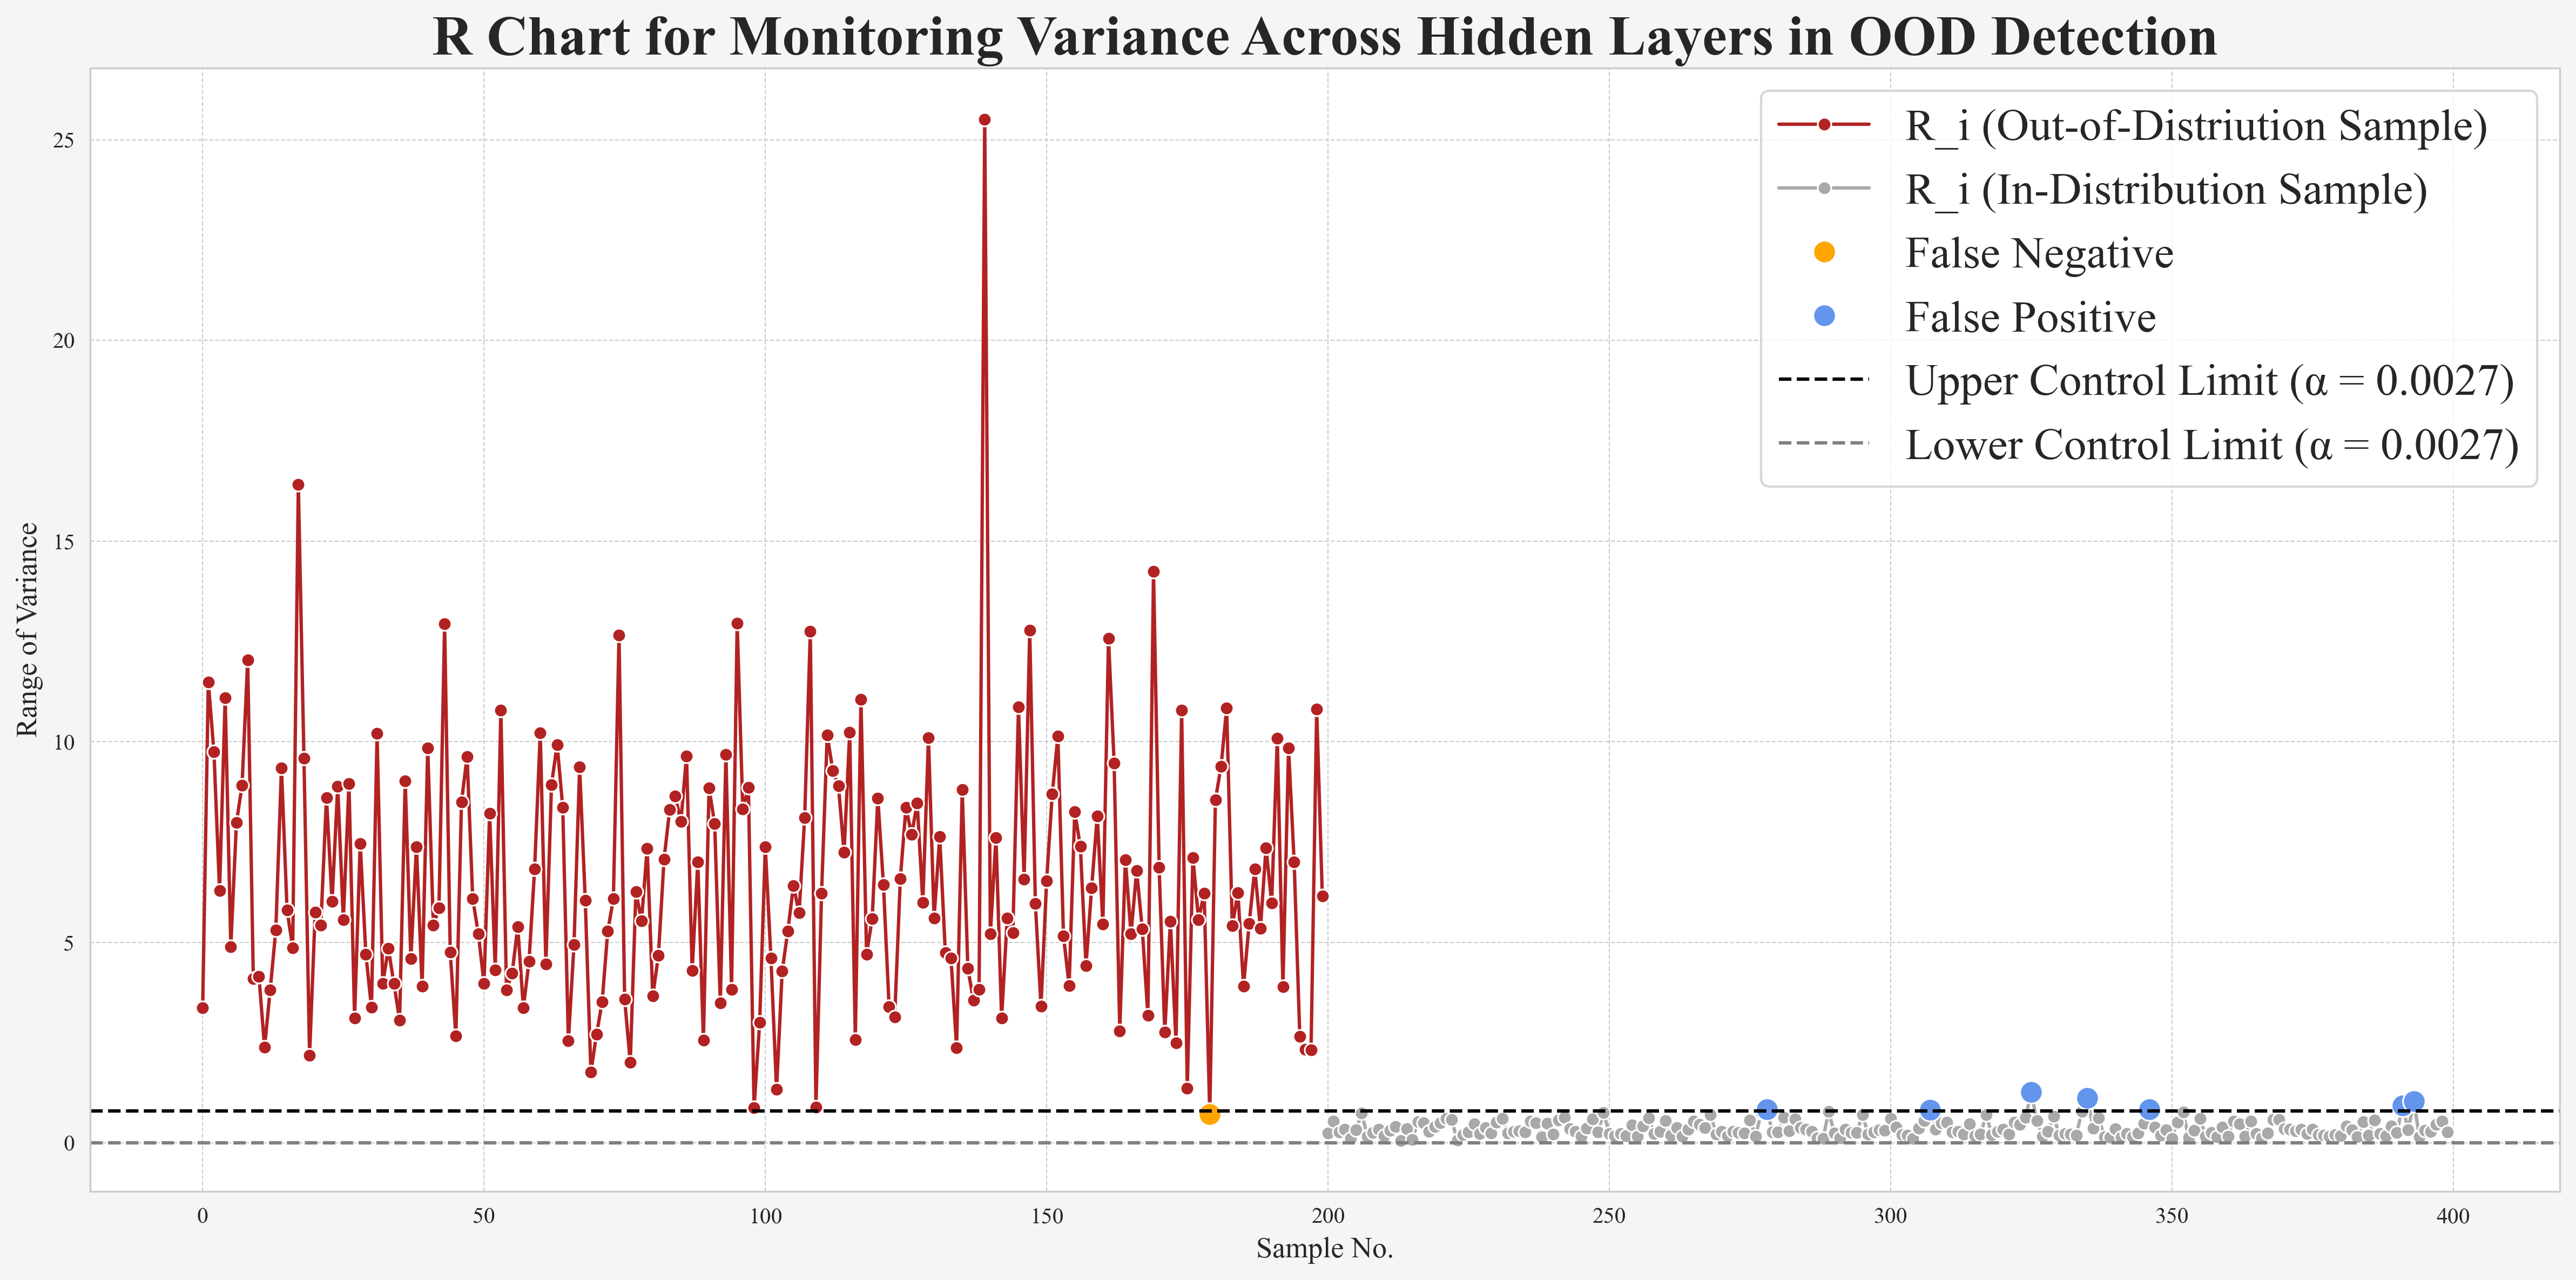

In [11]:
plt.figure(figsize=(16,8), dpi=300, facecolor='whitesmoke')

# Plot the variances for Out-Of-Distribution (OOD) and In-Distribution data points
ood_samples = np.array(variance_test['R_i'].to_list()[:200] + [np.nan] * 200)
id_samples = np.array([np.nan] * 200 + variance_test['R_i'].to_list()[200:])
sns.lineplot(ood_samples, marker='o', color='firebrick', label='R_i (Out-of-Distriution Sample)')
sns.lineplot(id_samples, marker='o', color='darkgray', label='R_i (In-Distribution Sample)')

# Highlight False Negative points (OOD data classified as In-Distribution)
sns.lineplot(x=np.where(ood_samples < range_upper_limit)[0],
             y=ood_samples[np.where(ood_samples < range_upper_limit)[0]],
             marker='o', markersize=10, color='orange', linestyle='None', label='False Negative')

# Highlight False Positive points (In-Distribution data classified as OOD)
sns.lineplot(x=np.where(id_samples >= range_upper_limit)[0],
             y=id_samples[np.where(id_samples >= range_upper_limit)[0]],
             marker='o', markersize=10, color='cornflowerblue', linestyle='None', label='False Positive')

# Plot the Upper Control Limit (UCL) line (3σ control limit)
plt.axhline(y=range_upper_limit, color='black', linestyle='--', label='Upper Control Limit (α = 0.0027)')
plt.axhline(y=range_lower_limit, color='gray', linestyle='--', label='Lower Control Limit (α = 0.0027)')

# Title and labels
plt.title('R Chart for Monitoring Variance Across Hidden Layers in OOD Detection', fontsize=25, fontweight='bold')
plt.xlabel('Sample No.', fontsize=13)
plt.ylabel('Range of Variance', fontsize=13)

# Light grid for clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust legend position
plt.legend(fontsize=20)
plt.tight_layout();

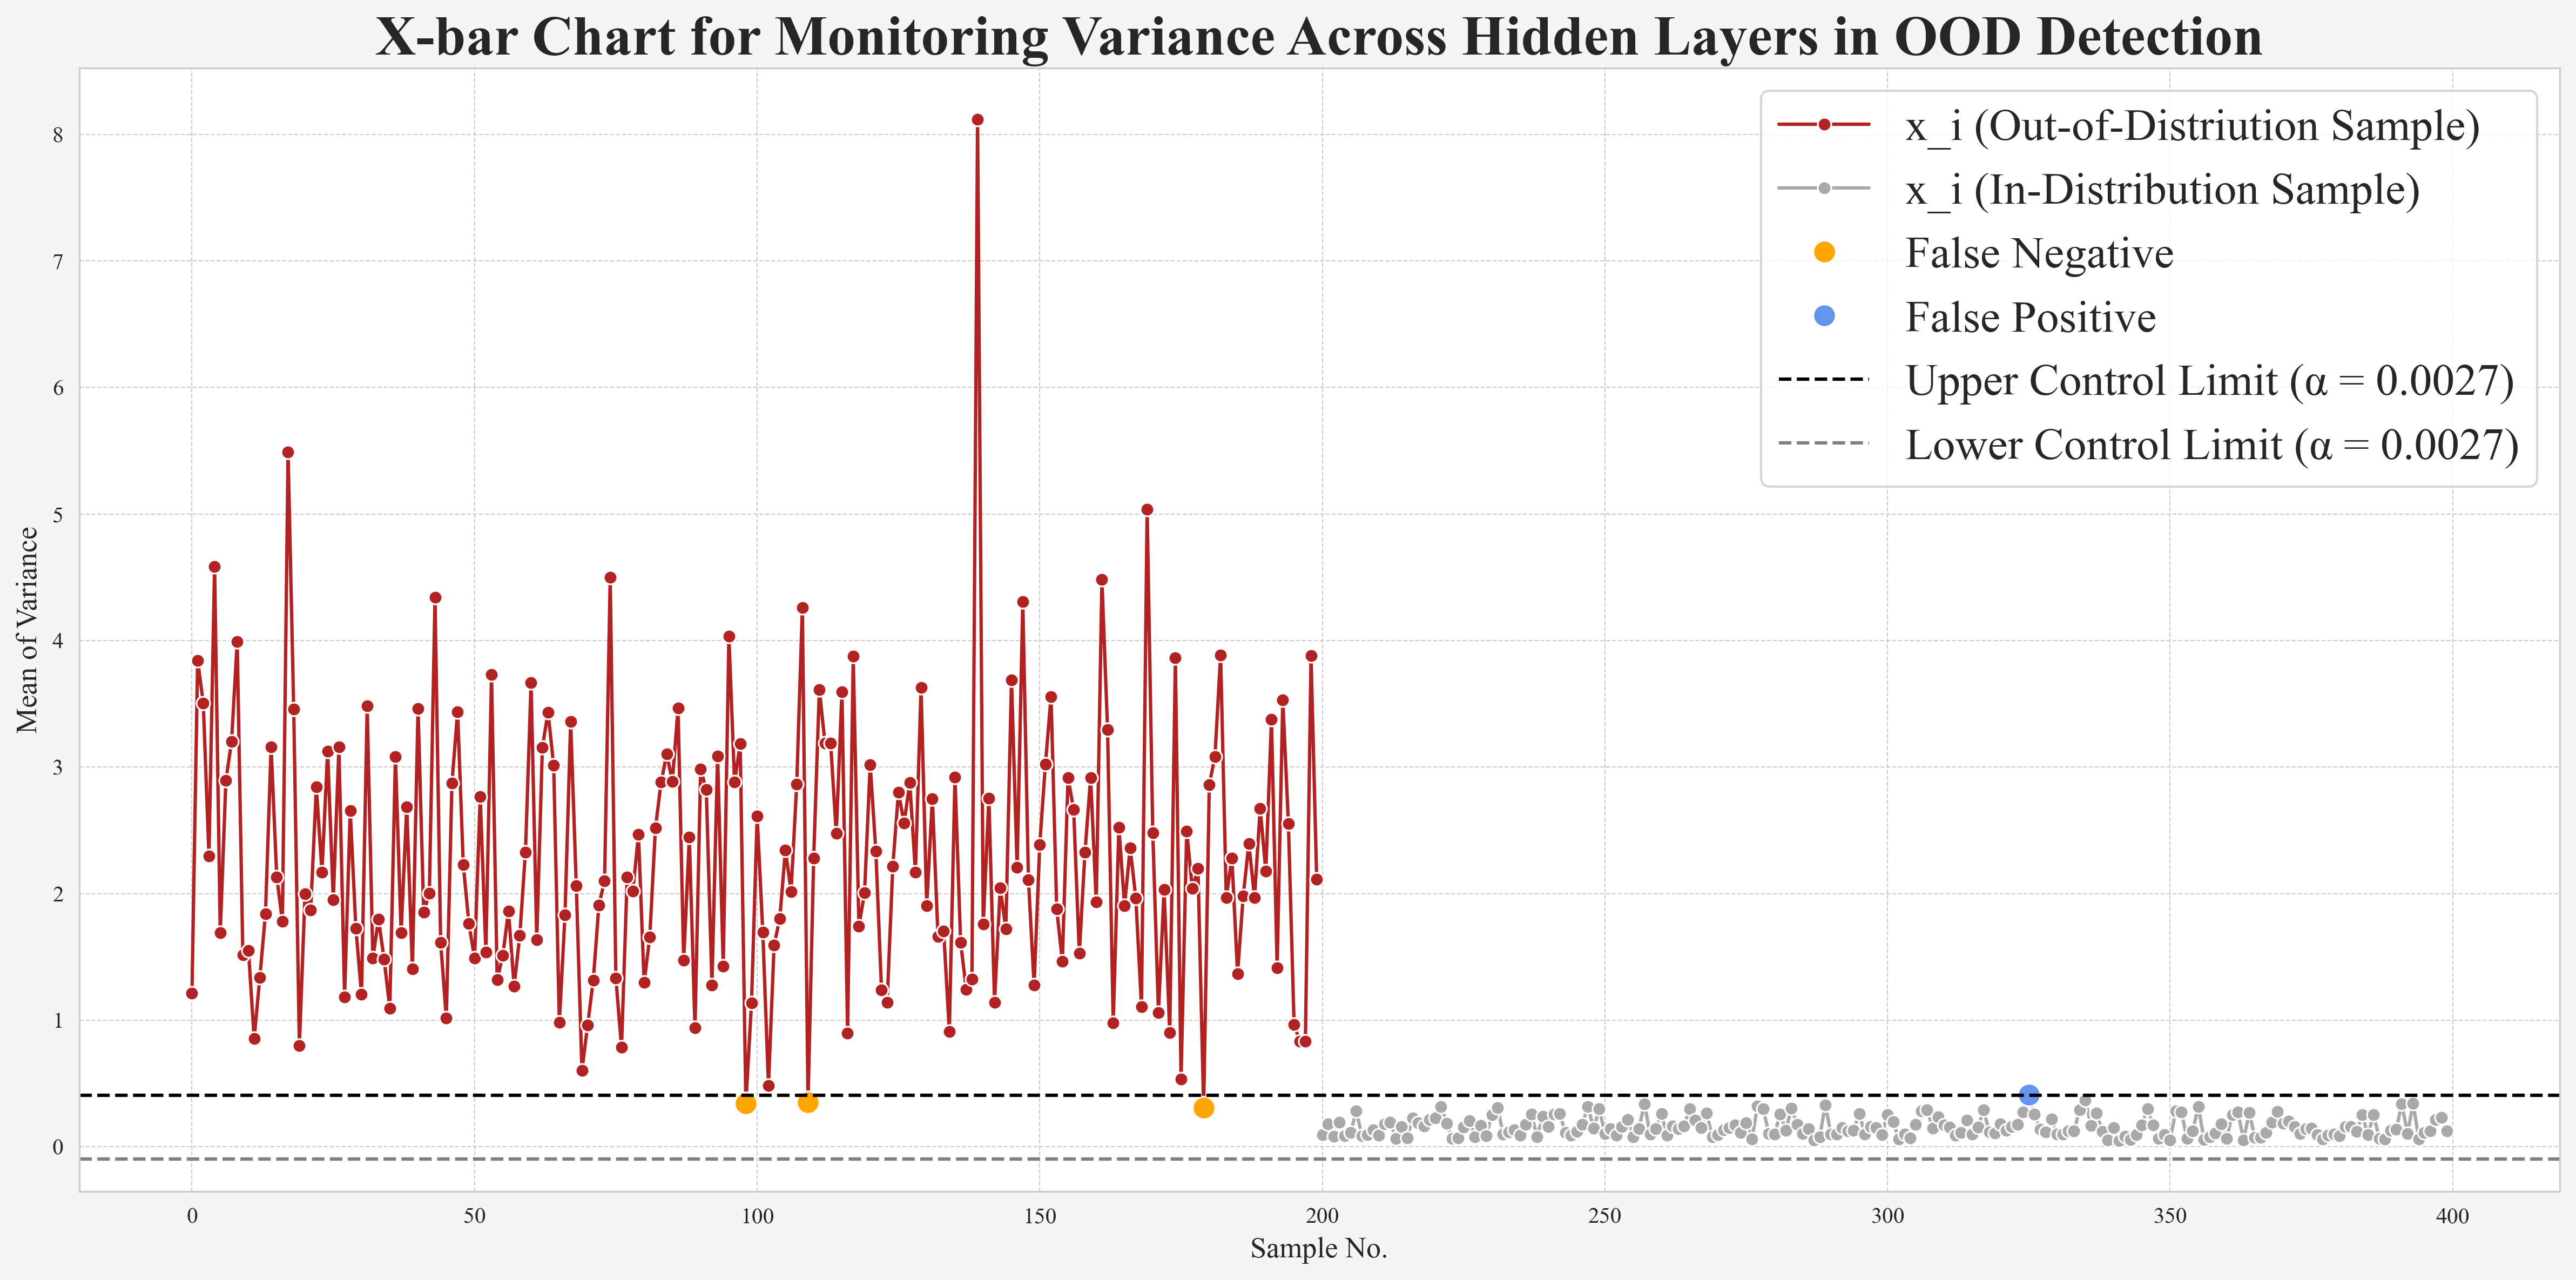

In [12]:
plt.figure(figsize=(16,8), dpi=300, facecolor='whitesmoke')

# Plot the variances for Out-Of-Distribution (OOD) data points
ood_samples = np.array(variance_test['x_i'].to_list()[:200] + [np.nan] * 200)
id_samples = np.array([np.nan] * 200 + variance_test['x_i'].to_list()[200:])
sns.lineplot(ood_samples, marker='o', color='firebrick', label='x_i (Out-of-Distriution Sample)')
sns.lineplot(id_samples, marker='o', color='darkgray', label='x_i (In-Distribution Sample)')

# Highlight False Negative points (OOD data classified as In-Distribution)
sns.lineplot(x=np.where(ood_samples < mean_upper_limit)[0],
             y=ood_samples[np.where(ood_samples < mean_upper_limit)[0]],
             marker='o', markersize=10, color='orange', linestyle='None', label='False Negative')

# Highlight False Positive points (In-Distribution data classified as OOD)
sns.lineplot(x=np.where(id_samples >= mean_upper_limit)[0],
             y=id_samples[np.where(id_samples >= mean_upper_limit)[0]],
             marker='o', markersize=10, color='cornflowerblue', linestyle='None', label='False Positive')

# Plot the Upper Control Limit (UCL) line (3σ control limit)
plt.axhline(y=mean_upper_limit, color='black', linestyle='--', label='Upper Control Limit (α = 0.0027)')
plt.axhline(y=mean_lower_limit, color='gray', linestyle='--', label='Lower Control Limit (α = 0.0027)')

# Title and labels
plt.title('X-bar Chart for Monitoring Variance Across Hidden Layers in OOD Detection', fontsize=25, fontweight='bold')
plt.xlabel('Sample No.', fontsize=13)
plt.ylabel('Mean of Variance', fontsize=13)

# Light grid for clarity
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust legend position
plt.legend(fontsize=20)
plt.tight_layout();